Python Questions:Python Question - 1:
Write Python code to fetch historical health care R&D spending data from a given data source and calculate the year-over-year percentage change for each year over the past four years.Python Question - 2:
Create a Python script that uses matplotlib library to generate a line chart or bar chart showing the trend in health care R&D spending for a specific company listed on the New York Stock Exchange over the past four years.SQL Questions:SQL Question - 3:
write an SQL query to retrieve the total health care R&D spending for all companies for each of the past four years.SQL Question - 4:
Write an SQL query to find the top three companies listed on the New York Stock Exchange with the highest percentage increase in health care R&D spending .

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [96]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

In [156]:
# Load data
df = pd.read_excel("../data/raw/companies.xlsx")

In [157]:
def normalize_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '')
    return df

In [166]:
# Normalize columns names
df_cleaned = normalize_column_names(df)
df_cleaned["years"] = df_cleaned["years"].replace("Year ", "", regex=True)
display(df_cleaned.head())
display(df_cleaned.dtypes)

# Filter columns that are useful to us
df_filtered = pd.DataFrame(df_cleaned, columns=['ticker_symbol', 'years', 'period_ending', 'research_and_development', 'gics_sector'])
# Make sure we only have the health care sector companies
df_filtered = df_filtered.loc[df_filtered['gics_sector'] == 'Health Care']
# Sort by ticket symbol and years early on
df_filtered = df_filtered.sort_values(['ticker_symbol', 'years'], ascending=True)
display(df_filtered.head())

/var/folders/t8/k_p89pr11hl5tqbxsmphfkyr0000gp/T/ipykernel_7475/2398183133.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '')
/var/folders/t8/k_p89pr11hl5tqbxsmphfkyr0000gp/T/ipykernel_7475/2398183133.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '')
/var/folders/t8/k_p89pr11hl5tqbxsmphfkyr0000gp/T/ipykernel_7475/2398183133.py:2: FutureWarning: The default value of regex will change from True to False in a futur

,ticker_symbol,years,period_ending,total_revenue,cost_of_goods_sold,sales_general_and_admin,research_and_development,other_operating_items,gics_sector,gics_sub_industry
0,AAL,1,2012-12-31,24855000000,10499000000,12977000000,0,845000000,Industrials,Airlines
1,AAL,2,2013-12-31,26743000000,11019000000,12913000000,0,853000000,Industrials,Airlines
2,AAL,3,2014-12-31,42650000000,15620000000,20686000000,0,1295000000,Industrials,Airlines
3,AAL,4,2015-12-31,40990000000,11096000000,21275000000,0,1364000000,Industrials,Airlines
4,AAP,1,2012-12-29,6205003000,3106967000,2440721000,0,0,Consumer Discretionary,Automotive Retail


ticker_symbol                       object
years                               object
period_ending               datetime64[ns]
total_revenue                        int64
cost_of_goods_sold                   int64
sales_general_and_admin              int64
research_and_development             int64
other_operating_items                int64
gics_sector                         object
gics_sub_industry                   object
dtype: object

,ticker_symbol,years,period_ending,research_and_development,gics_sector
12,ABBV,1,2012-12-31,2778000000,Health Care
13,ABBV,2,2013-12-31,2855000000,Health Care
14,ABBV,3,2014-12-31,3297000000,Health Care
15,ABBV,4,2015-12-31,4285000000,Health Care
16,ABC,1,2013-09-30,0,Health Care


In [189]:
# Yearly spending by companies from the health sector
yearly_company_spending = df_filtered.groupby(['ticker_symbol', 'years']).sum()
display(yearly_company_spending)

/var/folders/t8/k_p89pr11hl5tqbxsmphfkyr0000gp/T/ipykernel_7475/655514141.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_company_spending = df_filtered.groupby(['ticker_symbol', 'years']).sum()


research_and_development
ticker_symbol years                          
AAL           1                             0
              2                             0
              3                             0
              4                             0
AAP           1                             0
              2                             0
              3                             0
              4                             0
AAPL          1                    4475000000
              2                    6041000000
              3                    8067000000
              4                   10045000000
ABBV          1                    2778000000
              2                    2855000000
              3                    3297000000
              4                    4285000000
ABC           1                             0
              2                             0
              3                             0
              4                             0
ABT           1                    1461000000
              2                    1371000000
              3                    1345000000
              4                    1405000000
ADBE          1                     826631000
              2                     844353000
              3                     862730000
              4                     975987000
ADI           1                     513035000
              2                     559686000
              3                     637459000
              4                     653816000
ADM           1                             0
              2                             0
              3                             0
              4                             0
ADS           1                             0
              2                             0
              3                             0
              4                             0
ADSK          1                     600000000
              2                     611100000
              3                     725200000
              4                     790000000
AEE           1                             0
              2                             0
              3                             0
              4                             0
AEP           1                             0
              2                             0
              3                             0
              4                             0
AFL           1                             0
              2                             0
              3                             0
              4                             0
AIG           1                             0
              2                             0
              3                             0
              4                             0
AIV           1                             0
              2                             0
              3                             0
              4                             0
AIZ           1                             0
              2                             0
              3                             0
              4                             0
AKAM          1                      74744000
              2                      93879000
              3                     125286000
              4                     148591000
ALB           1                      78919000
              2                      82246000
              3                      88310000
              4                     102871000
ALK           1                             0
              2                             0
              3                             0
              4                             0
ALL           1                             0
              2                             0
              3                             0
              4                             0
ALLE          1                             0
              2    

In [190]:
# Aggregated yearly spending change across the companies
yearly_spending = df_filtered.groupby('years')["research_and_development"].sum().reset_index()
yearly_spending["spending_change"] = yearly_spending['research_and_development'].pct_change()
# Fix NaN
yearly_spending = yearly_spending.fillna(0)
# Round off change
yearly_spending["spending_change"] = yearly_spending["spending_change"].round(4)
display(yearly_spending)

,years,research_and_development,spending_change
0,1,144099439000,0.0000
1,2,152276450000,0.0567
2,3,159672290000,0.0486
3,4,165414013000,0.0360


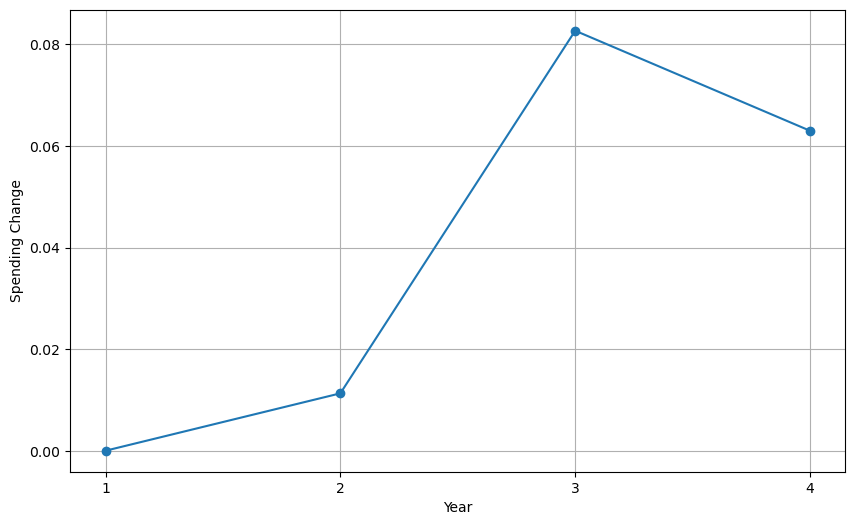

In [184]:
# Plotting YoY R&D spending change in the health sector
plt.figure(figsize=(10,6))
plt.plot(yearly_spending['years'], yearly_spending['spending_change'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Spending Change')
plt.grid(True)
plt.show()

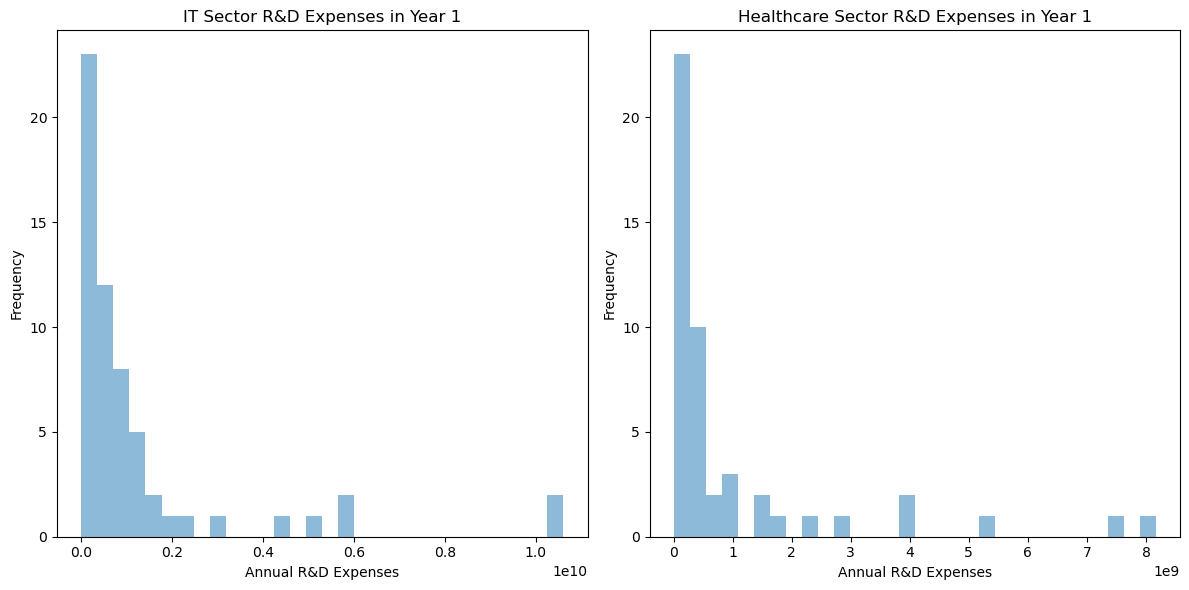

In [203]:
# Filter for Year 1
df_2 = df_filtered.copy()
df_2_year1 = df_2[df_2['years'] == '1']

# Separate data for healthcare and IT sectors
healthcare_data = df_2_year1[df_2_year1['gics_sector'] == 'Health Care']
it_data = df_2_year1[df_2_year1['gics_sector'] == 'Information Technology']

# Create a subplot with two histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for the IT sector
axes[0].hist(it_data['research_and_development'], bins=30, alpha=0.5)
axes[0].ticklabel_format(axis='x', scilimits=[0, 0])
axes[0].set_xlabel('Annual R&D Expenses')
axes[0].set_ylabel('Frequency')
axes[0].set_title('IT Sector R&D Expenses in Year 1')

# Plot histogram for the healthcare sector
axes[1].hist(healthcare_data['research_and_development'], bins=30, alpha=0.5)
axes[1].ticklabel_format(axis='x', scilimits=[0, 0])
axes[1].set_xlabel('Annual R&D Expenses')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Healthcare Sector R&D Expenses in Year 1')

plt.tight_layout()
plt.show()


In [233]:

fig = px.treemap(
    top_15_rd_spending,
    path=['ticker_symbol'],
    values='research_and_development',
    color='research_and_development',
    color_continuous_scale='blues',
    title='Top 20 Companies with Highest R&D Spending in Health Care Sector (Treemap)'
)

# Show the treemap
fig.show()


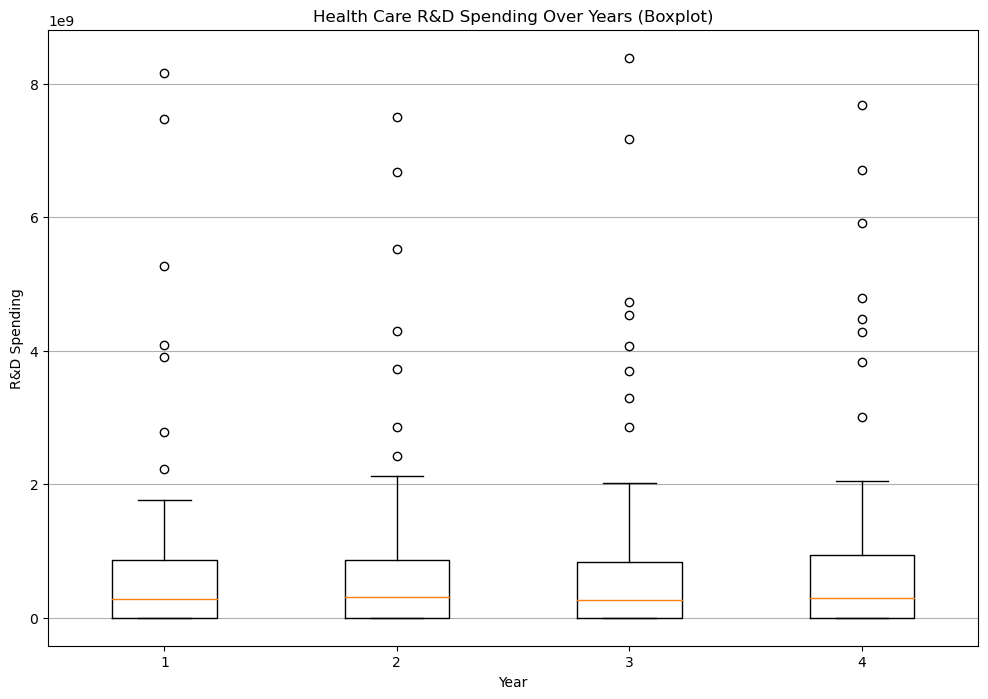

In [226]:


# Filter for companies in the Health Care sector
healthcare_data = df_filtered[df_filtered['gics_sector'] == 'Health Care']

# Create a boxplot to visualize R&D spending over the years
plt.figure(figsize=(12, 8))
plt.boxplot([healthcare_data[healthcare_data['years'] == year]['research_and_development'] for year in healthcare_data['years'].unique()], 
            labels=healthcare_data['years'].unique())
plt.xlabel('Year')
plt.ylabel('R&D Spending')
plt.title('Health Care R&D Spending Over Years (Boxplot)')
plt.grid(axis='y')
plt.show()


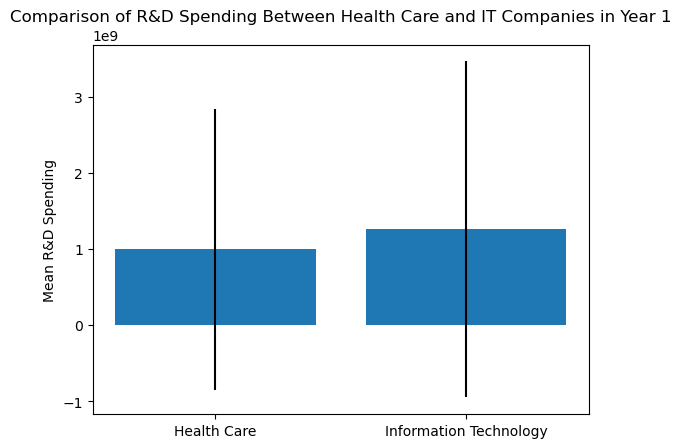

T-statistic: -0.6629408561450465
P-value: 0.5088224903434878


In [227]:

# Filter data for Year 1
year1_data = df_filtered[df_filtered['years'] == '1']

# Separate data for Health Care and IT sectors
healthcare_data = year1_data[year1_data['gics_sector'] == 'Health Care']
it_data = year1_data[year1_data['gics_sector'] == 'Information Technology']

# Perform a t-test to compare the R&D spending distributions
t_stat, p_value = ttest_ind(healthcare_data['research_and_development'], it_data['research_and_development'], equal_var=False)

# Visualize the results using a bar chart
plt.bar(['Health Care', 'Information Technology'], [healthcare_data['research_and_development'].mean(), it_data['research_and_development'].mean()], yerr=[healthcare_data['research_and_development'].std(), it_data['research_and_development'].std()])
plt.ylabel('Mean R&D Spending')
plt.title('Comparison of R&D Spending Between Health Care and IT Companies in Year 1')
plt.show()

# Print the t-test results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')
